In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os 
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit import Chem



## EDA + Distribution 


In [3]:
# load CSV files from the output/property_analysis folder
enamine_protein_csv = pd.read_csv('output/v2/property_analysis/enamine_protein.csv')
enamine_rna_csv = pd.read_csv('output/v2/property_analysis/enamine_rna.csv')
chemdiv_rna_csv = pd.read_csv('output/v2/property_analysis/chemdiv_rna.csv')
life_chemicals_csv = pd.read_csv('output/v2/property_analysis/life_chemicals.csv')
robin_df_csv = pd.read_csv('output/v2/property_analysis/robin_df.csv')

In [4]:
combined_df = pd.concat([enamine_protein_csv, enamine_rna_csv, chemdiv_rna_csv, life_chemicals_csv, robin_df_csv], ignore_index=True)
# remove duplicates
combined_df = combined_df.drop_duplicates('SMILES', keep=False)

enamine_protein_csv = combined_df[combined_df['source'] == 'enamine_protein']
enamine_rna_csv = combined_df[combined_df['source'] == 'enamine']
chemdiv_rna_csv = combined_df[combined_df['source'] == 'chemdiv']
life_chemicals_csv = combined_df[combined_df['source'] == 'life_chemicals']
robin_df_csv = combined_df[combined_df['source'] == 'robin']


In [5]:
all_dataframes = [enamine_protein_csv, enamine_rna_csv, chemdiv_rna_csv, life_chemicals_csv, robin_df_csv]

In [6]:
# create folder histograms
if not os.path.exists('../output/histograms/v2'):
    os.makedirs('../output/histograms/v2')

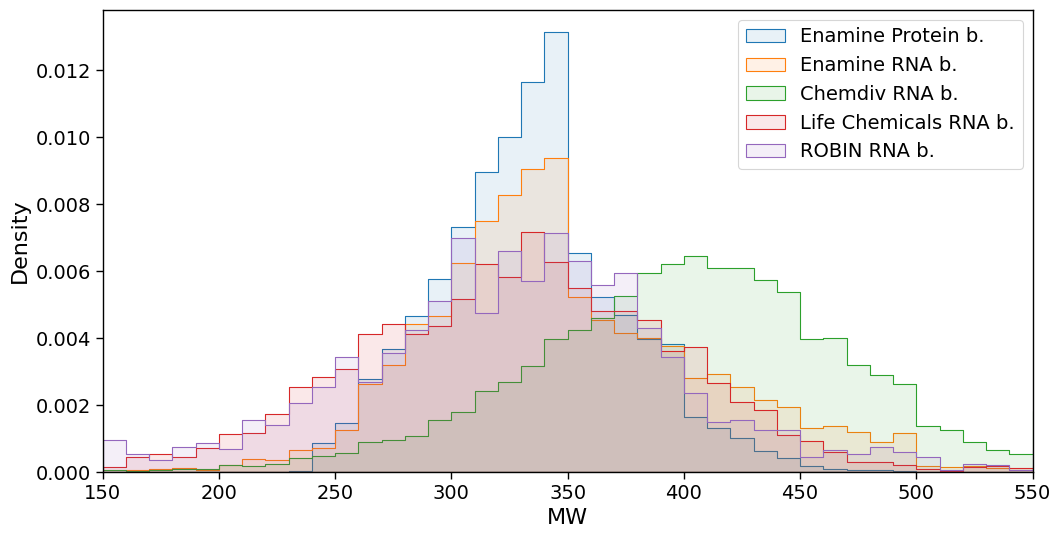

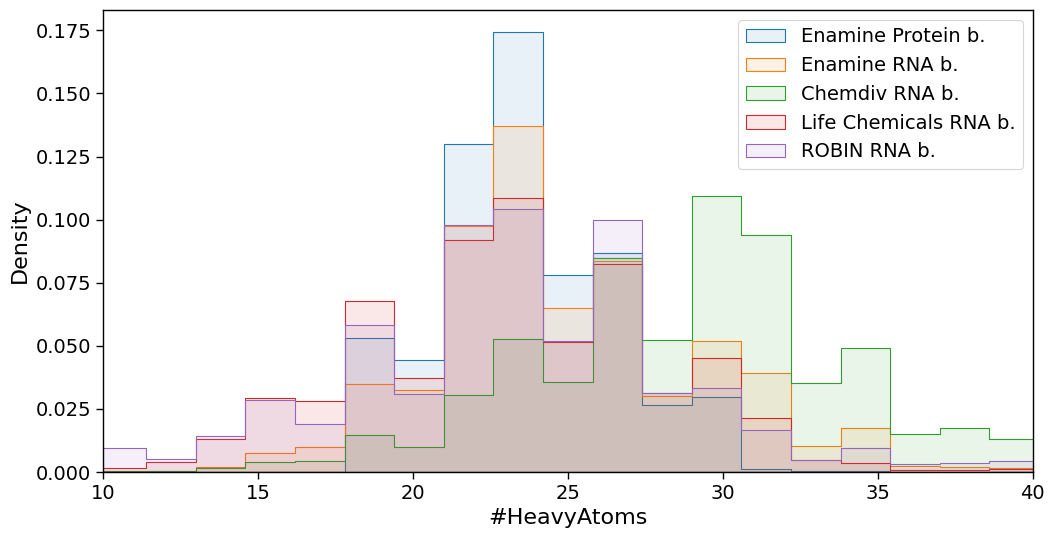

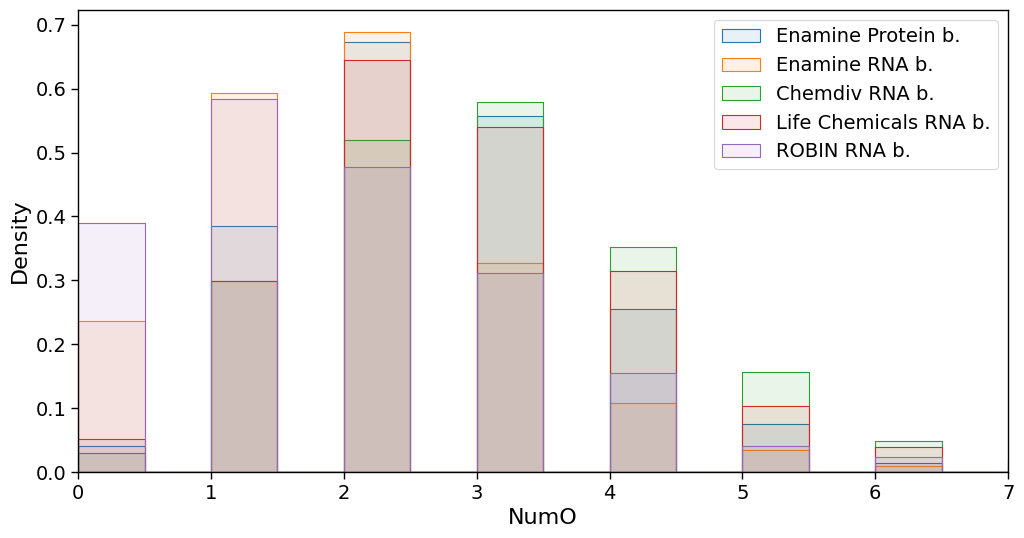

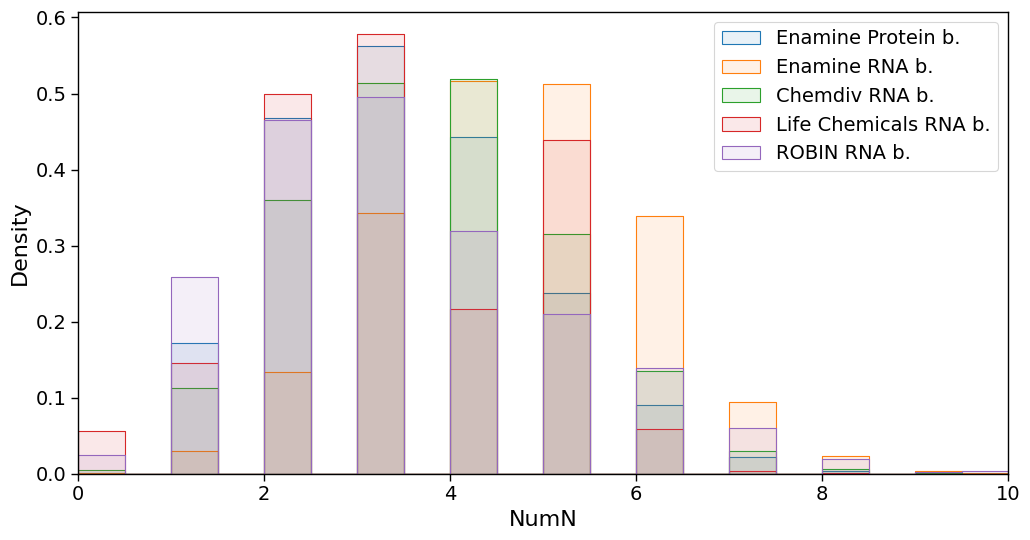

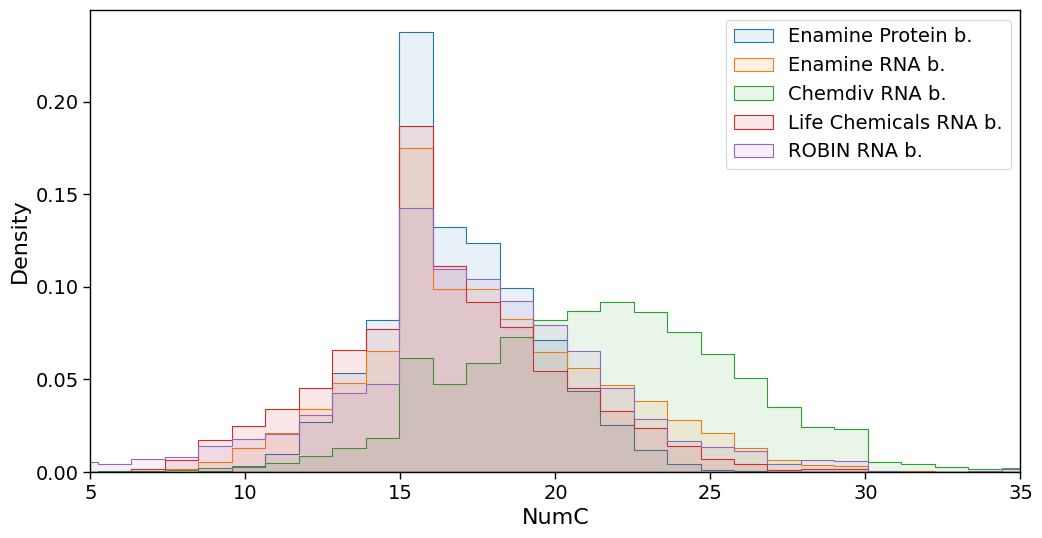

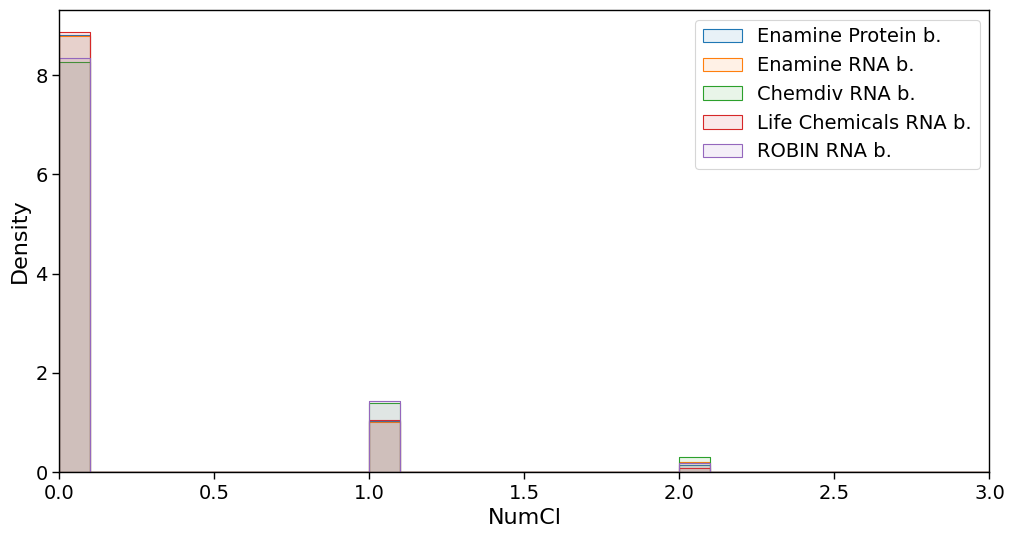

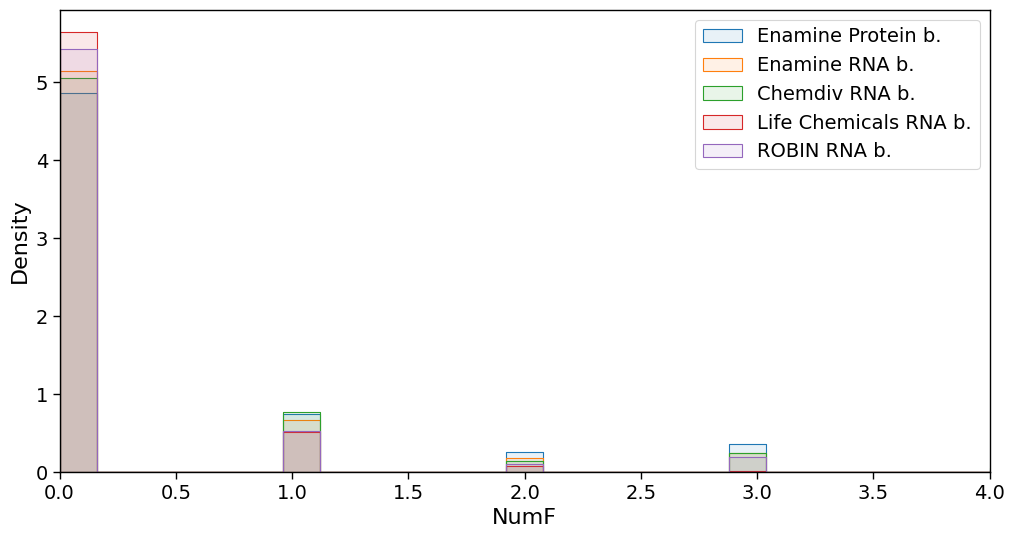

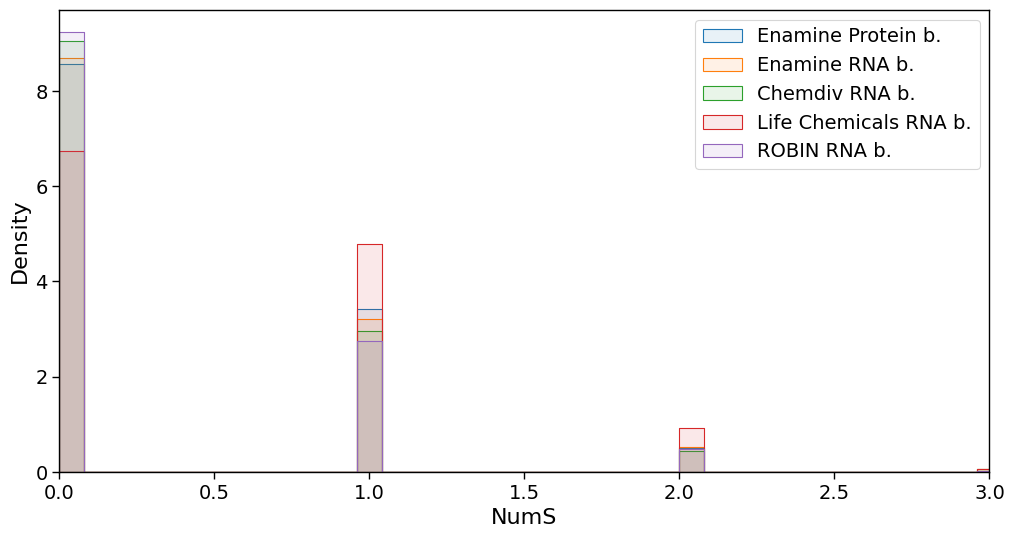

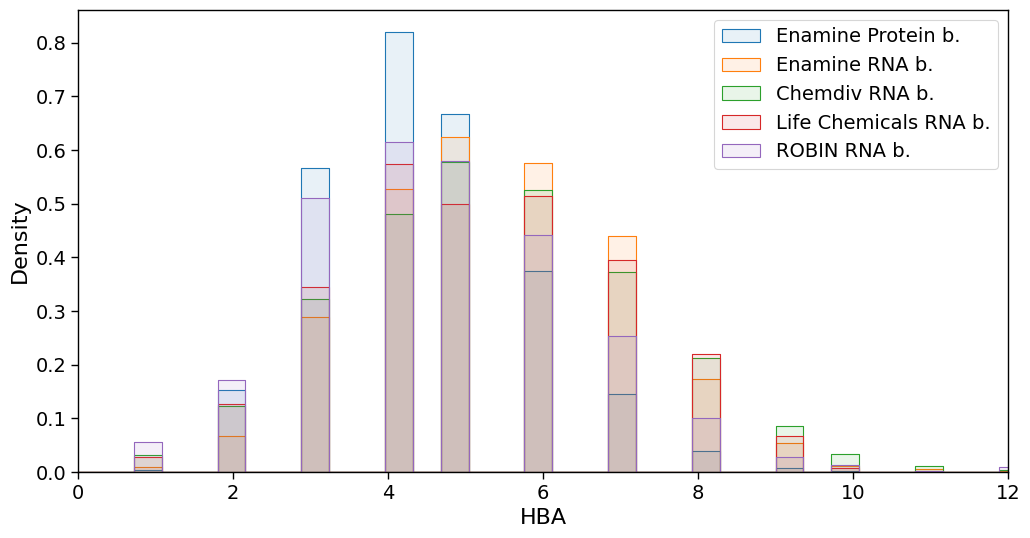

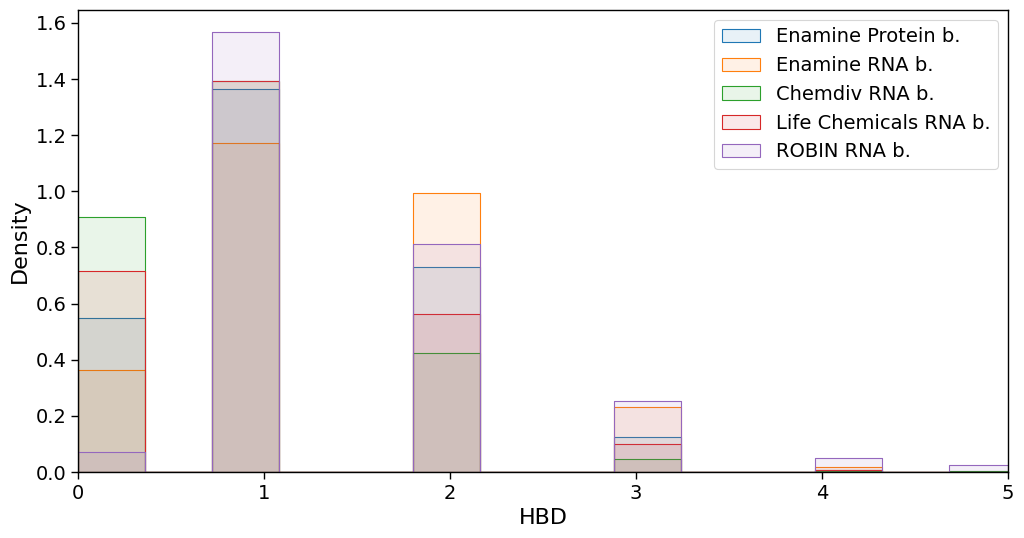

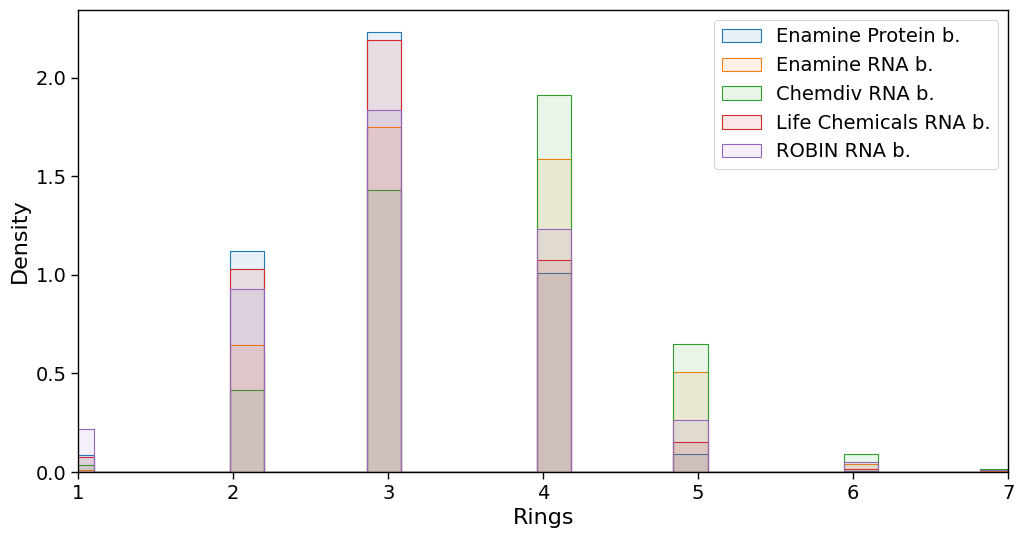

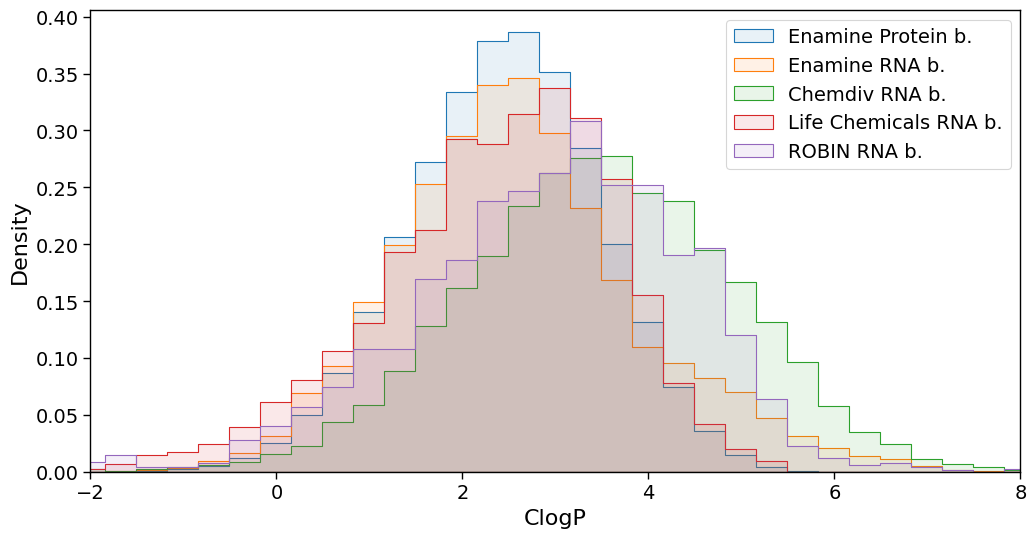

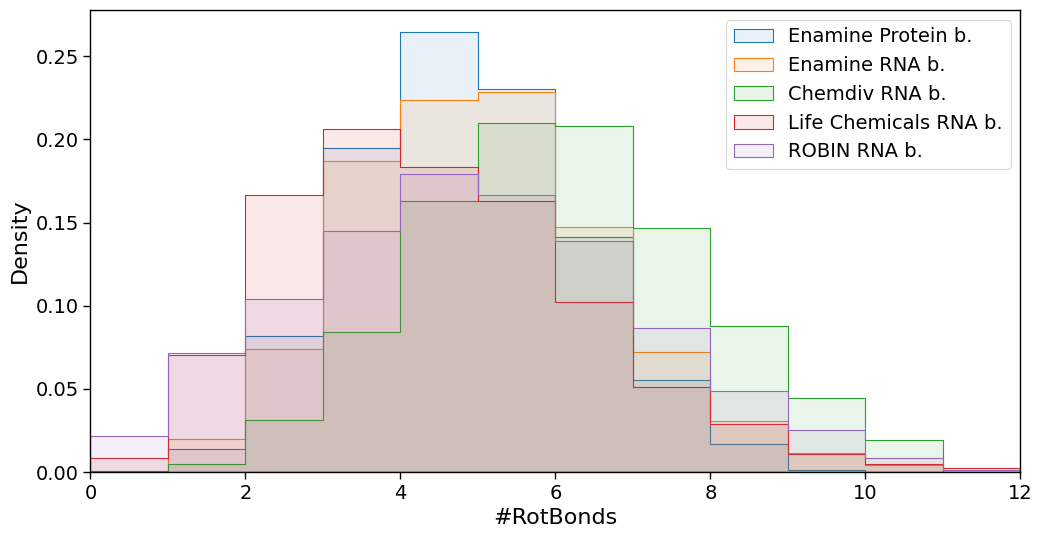

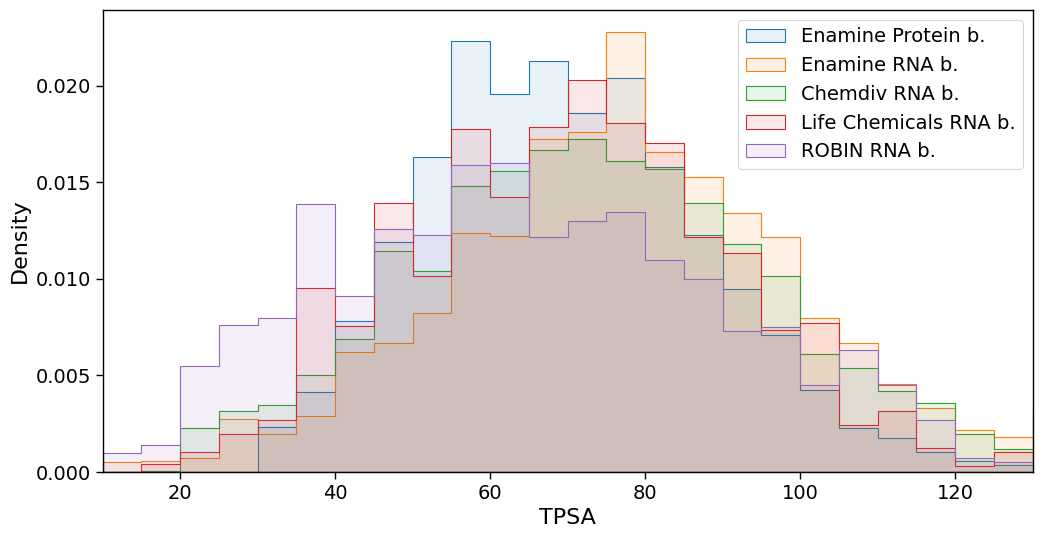

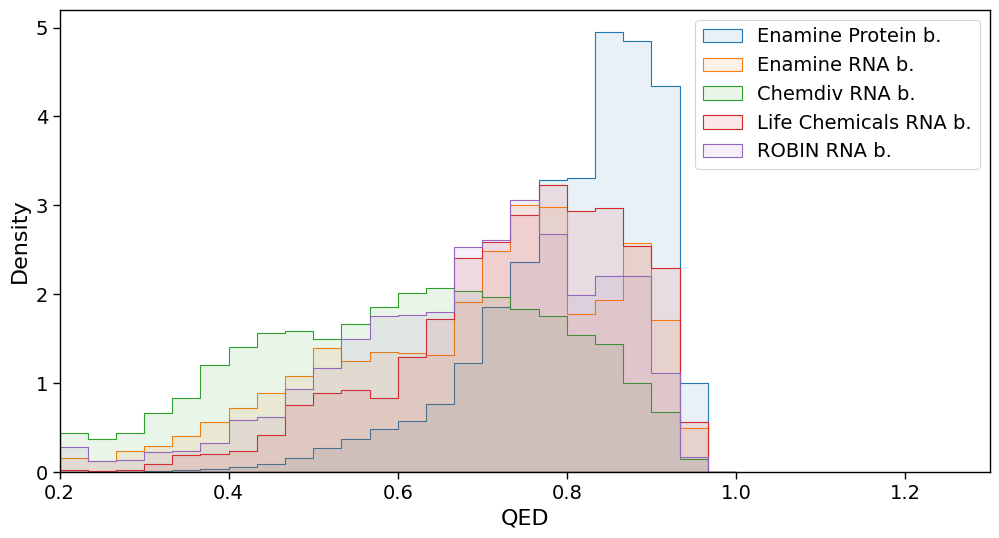

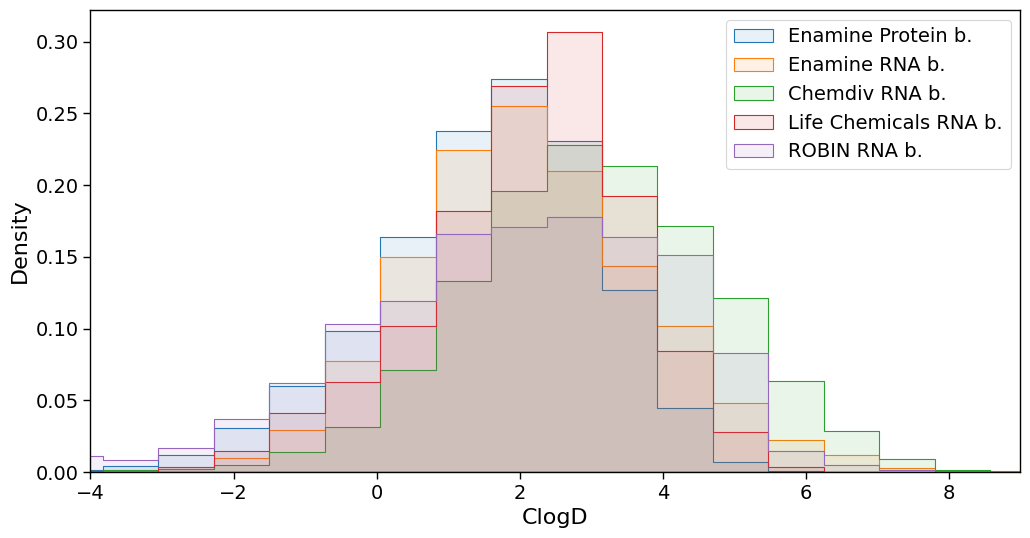

In [8]:

def get_bins(column, datasets, num_bins=50, custom_max=None, round_int=False, custom_bins=None):
    if column in ['MW', '#HeavyAtoms', 'NumO', 'NumN', 'NumC', 'NumCl', 'NumF', 'NumS', 'HBA', 'HBD', 'Rings', 'ClogP', '#RotBonds', 'TPSA', 'QED', 'ClogD']:
        if custom_bins and column in custom_bins:
            bin_edges = custom_bins[column]
        else:
            min_val = min(min(data[column]) for data in datasets)
            max_val = max(max(data[column]) for data in datasets)
            if round_int:
                min_val = int(round(min_val))
                max_val = int(round(max_val))
            if custom_max:
                max_val = min(max_val, custom_max)
            bin_edges = np.linspace(min_val, max_val, num_bins + 1)
        return bin_edges
    else:
        return num_bins


def plot_histograms_seaborn(datasets, column, labels, alpha=0.1, custom_max=None, round_int=False, custom_bins=None, x_range=None):
    sns.set_context("paper")
    
    plt.figure(figsize=(12, 6))
    custom_bins = get_bins(column, datasets, custom_max=custom_max, round_int=round_int, custom_bins=custom_bins)
    
    if isinstance(custom_bins, int) or np.all(np.diff(custom_bins) > 0):
        for data, label in zip(datasets, labels):
            if x_range:
                data = data.copy()
                data[column] = np.where(data[column] < x_range[0], x_range[0], data[column])
                data[column] = np.where(data[column] > x_range[1], x_range[1], data[column])

            ax = sns.histplot(data[column], 
                              bins=custom_bins, 
                              alpha=alpha, 
                              label=label, 
                              kde=False, 
                              element="step", 
                              stat="density")

            if x_range:
                ax.set_xlim(x_range)

        ax.tick_params(axis='both', which='major', labelsize=14)
        plt.legend(loc='best', fontsize=14)

        plt.xlabel(column, fontsize=16)
        plt.ylabel('Density', fontsize=16)
        
        plt.savefig(f'../output/histograms/v2/{column}.pdf', dpi=300, format='pdf')
        plt.savefig(f'../output/histograms/v2/{column}.png', dpi=300, format='png')
        plt.show()
    else:
        print(f'Error: Invalid bin edges for column {column}.')


# Example usage
all_dataframes = [enamine_protein_csv, enamine_rna_csv, chemdiv_rna_csv, life_chemicals_csv, robin_df_csv]
labels = ['Enamine Protein b.', 'Enamine RNA b.', 'Chemdiv RNA b.', 'Life Chemicals RNA b.', 'ROBIN RNA b.']
columns = ['MW', '#HeavyAtoms', 'NumO', 'NumN', 'NumC', 'NumCl', 'NumF', 'NumS', 'HBA', 'HBD', 'Rings', 'ClogP', '#RotBonds', 'TPSA', 'QED', 'ClogD']
custom_bins = {
    'MW': np.linspace(0, 1000, 101), 
    'NumO': np.linspace(0, 10, 21), 
    'HeavyAtomCount': np.linspace(0, 50, 51), 
    'TPSA': np.linspace(0, 200, 41),
    'QED': np.linspace(0, 1, 31), 
    'NumN': np.linspace(0, 10, 21), 
    '#RotBonds': np.linspace(0, 20, 21), 
    'ClogD': np.linspace(-17, 14, 41)
}

plot_histograms_seaborn(all_dataframes, 'MW', labels, custom_bins=custom_bins, x_range=(150, 550))
plot_histograms_seaborn(all_dataframes, '#HeavyAtoms', labels, custom_bins=custom_bins, x_range=(10, 40))
plot_histograms_seaborn(all_dataframes, 'NumO', labels, custom_bins=custom_bins, x_range=(0, 7))
plot_histograms_seaborn(all_dataframes, 'NumN', labels, custom_bins=custom_bins, x_range=(0, 10))
plot_histograms_seaborn(all_dataframes, 'NumC', labels, custom_bins=custom_bins, x_range=(5, 35))
plot_histograms_seaborn(all_dataframes, 'NumCl', labels, custom_bins=custom_bins, x_range=(0, 3))
plot_histograms_seaborn(all_dataframes, 'NumF', labels, x_range=(0, 4))
plot_histograms_seaborn(all_dataframes, 'NumS', labels, custom_bins=custom_bins, x_range=(0, 3))
plot_histograms_seaborn(all_dataframes, 'HBA', labels, custom_bins=custom_bins, x_range=(0, 12))
plot_histograms_seaborn(all_dataframes, 'HBD', labels, custom_bins=custom_bins, x_range=(0, 5))
plot_histograms_seaborn(all_dataframes, 'Rings', labels, custom_bins=custom_bins, x_range=(1, 7))
plot_histograms_seaborn(all_dataframes, 'ClogP', labels, custom_bins=custom_bins, x_range=(-2, 8))
plot_histograms_seaborn(all_dataframes, '#RotBonds', labels, custom_bins=custom_bins, x_range=(0, 12))
plot_histograms_seaborn(all_dataframes, 'TPSA', labels, custom_bins=custom_bins, x_range=(10, 130))
plot_histograms_seaborn(all_dataframes, 'QED', labels, custom_bins=custom_bins, x_range=(0.2, 1.3))
plot_histograms_seaborn(all_dataframes, 'ClogD', labels, custom_bins=custom_bins, x_range=(-4, 9))


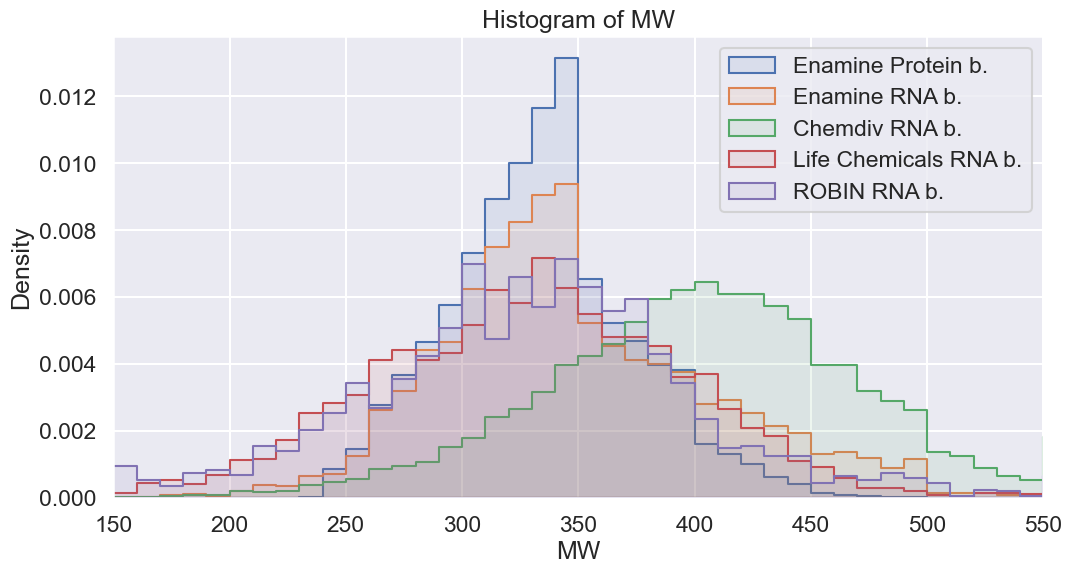

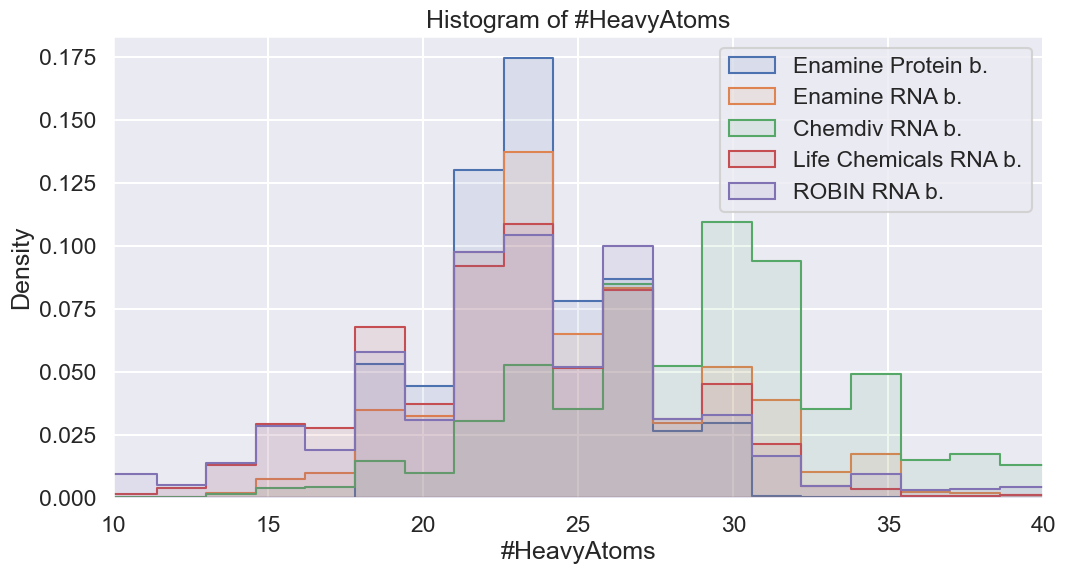

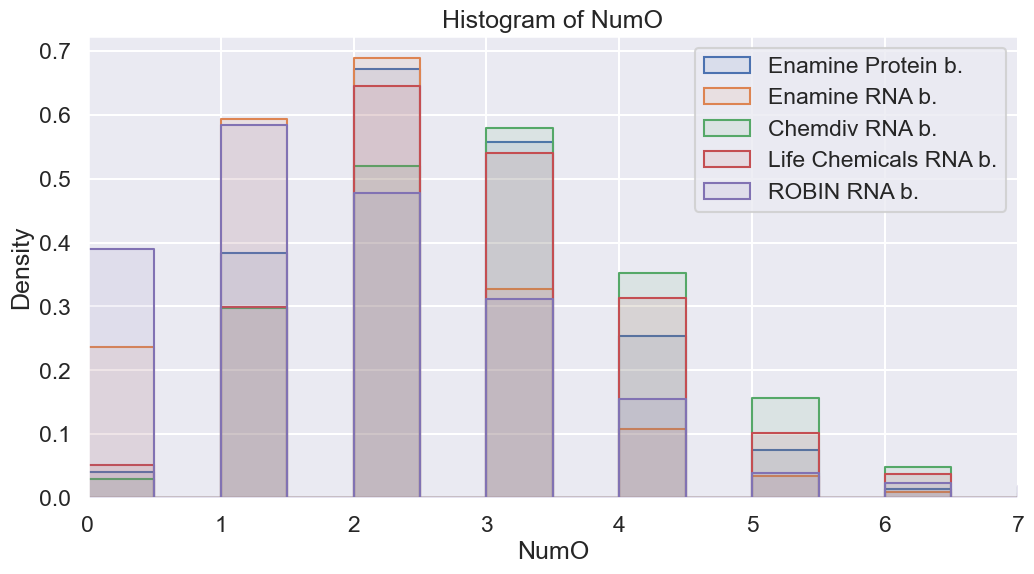

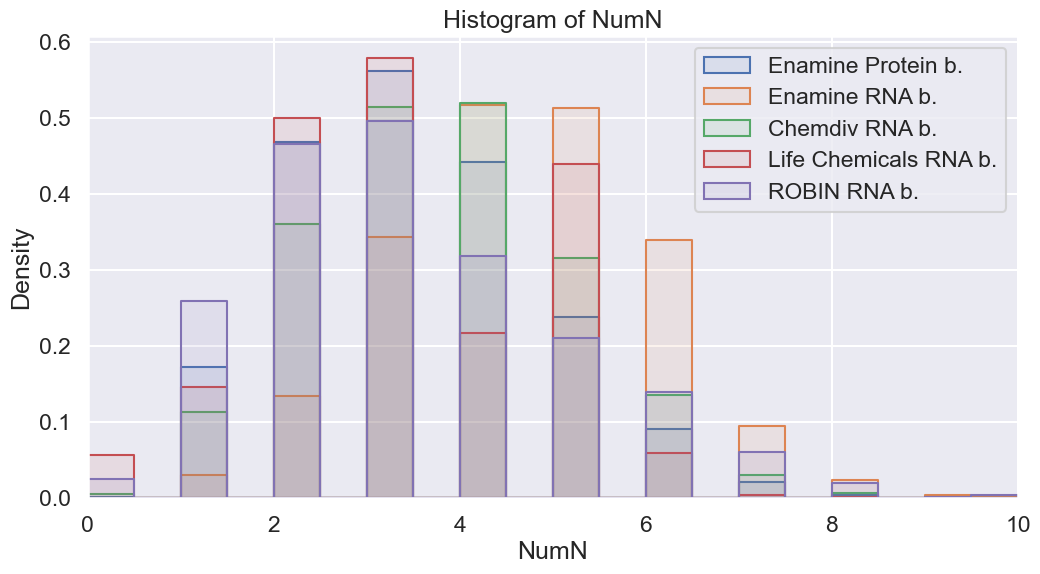

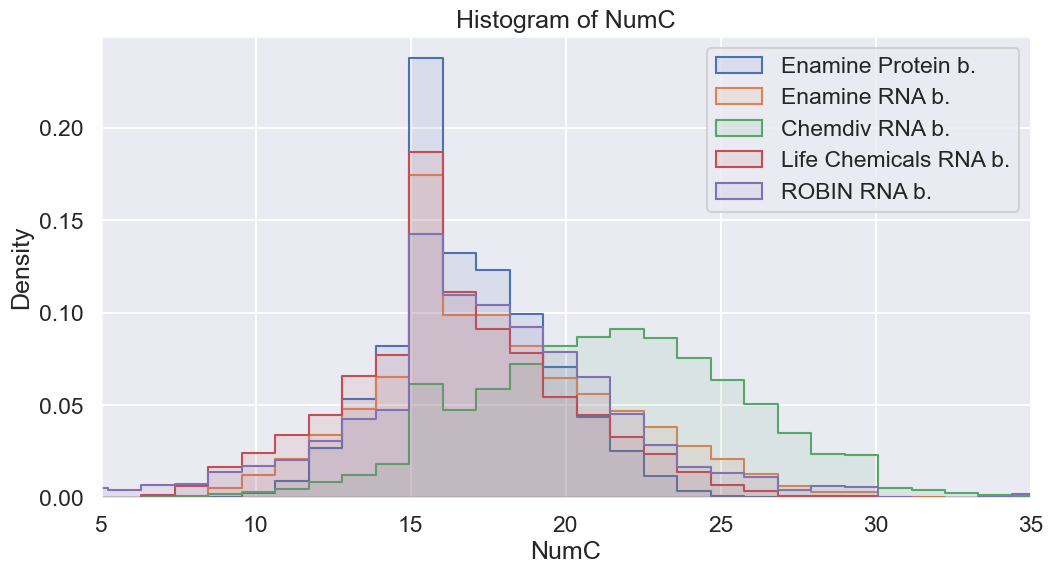

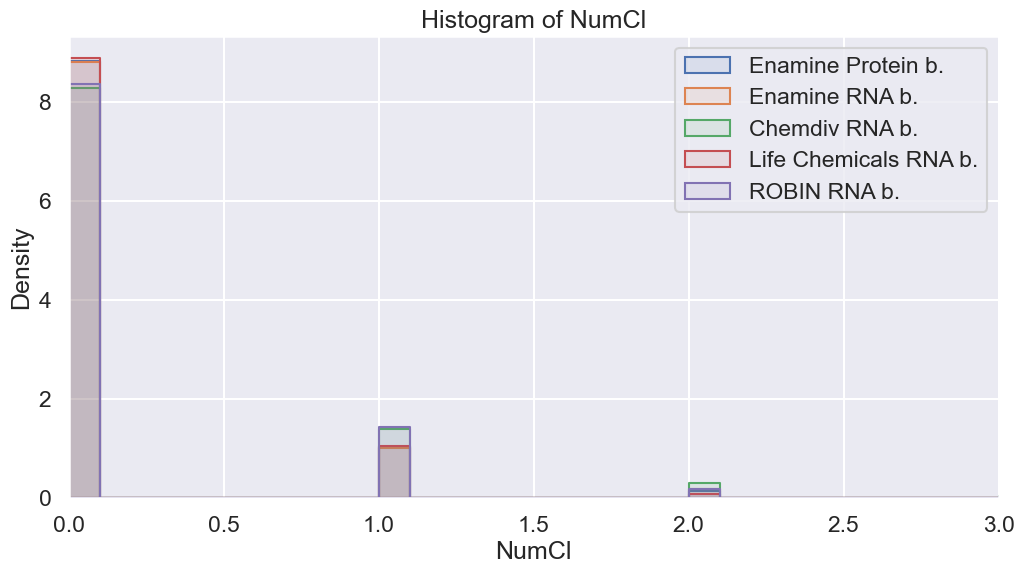

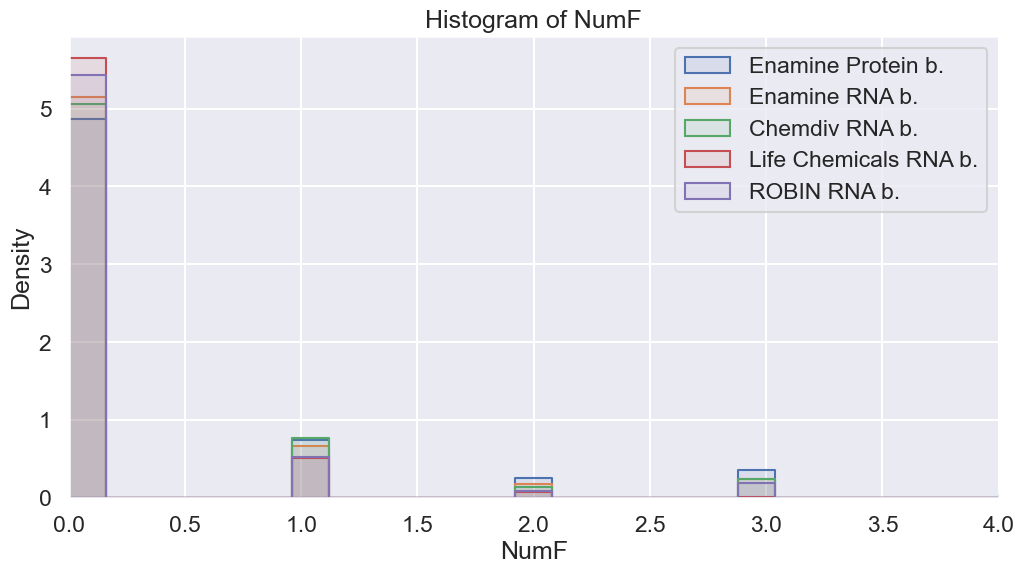

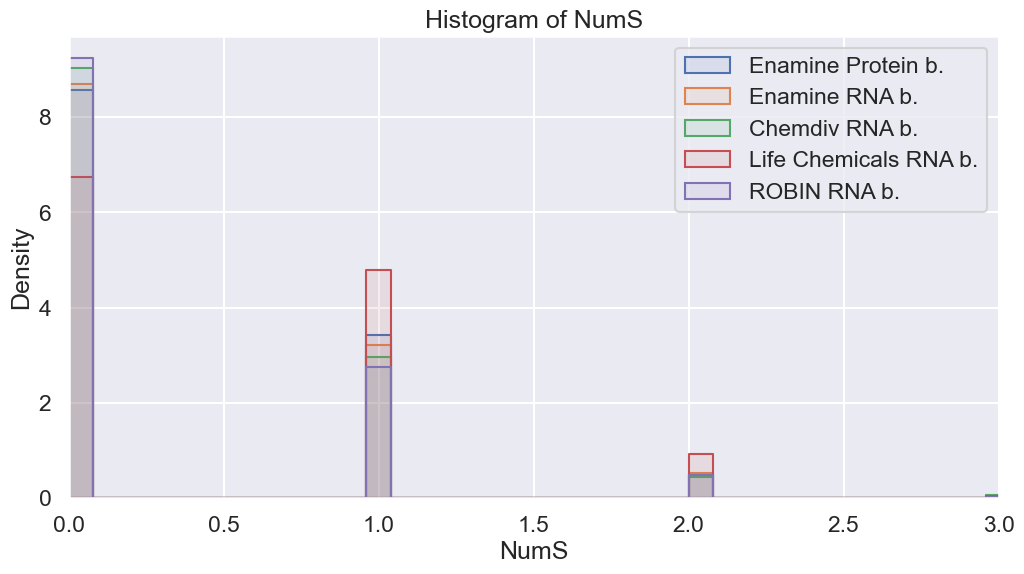

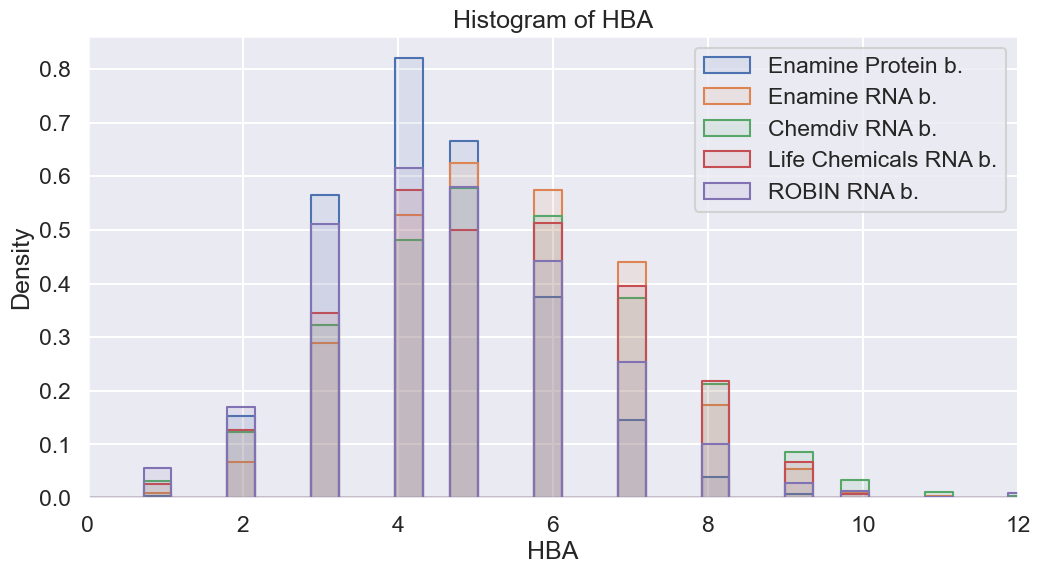

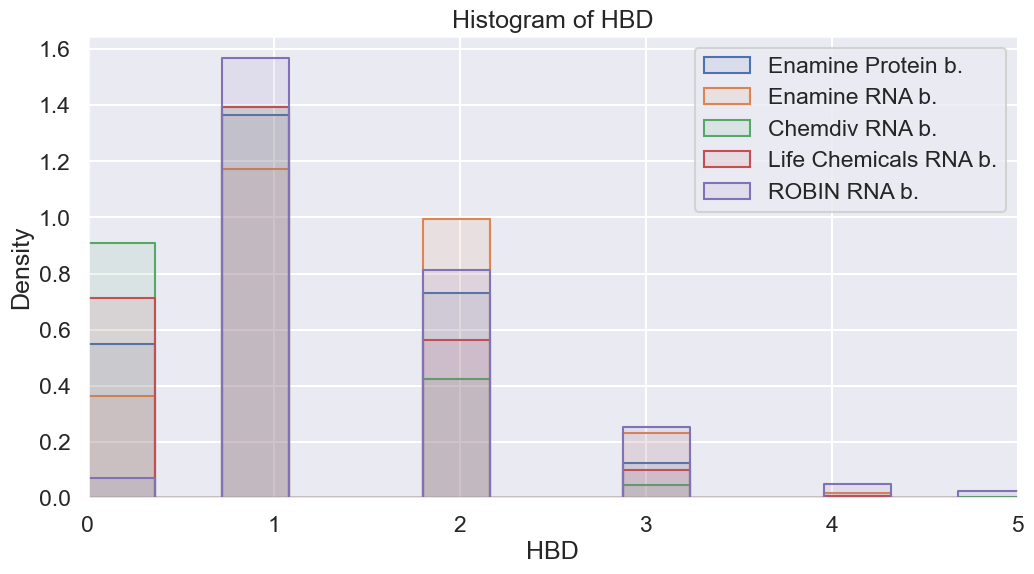

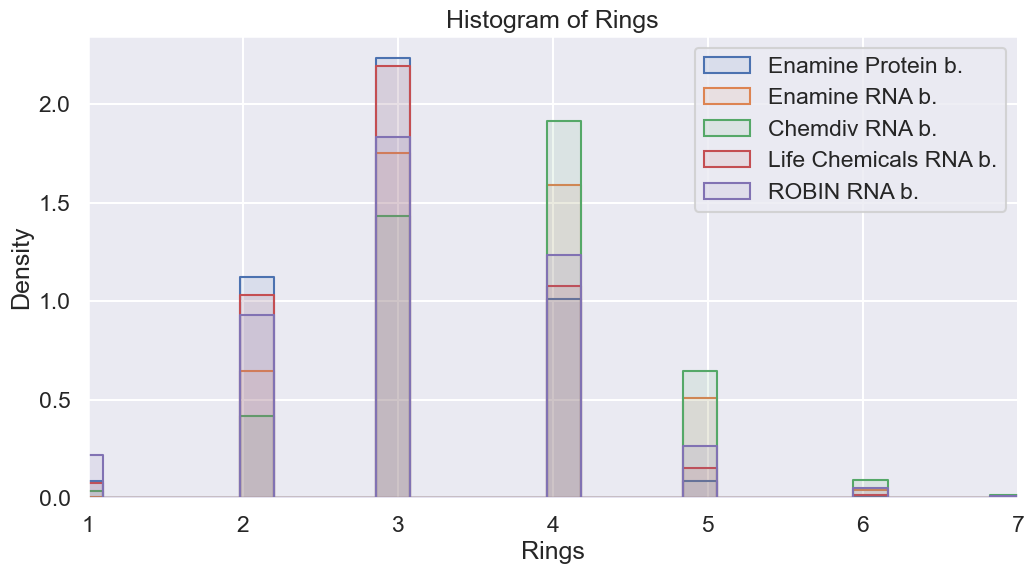

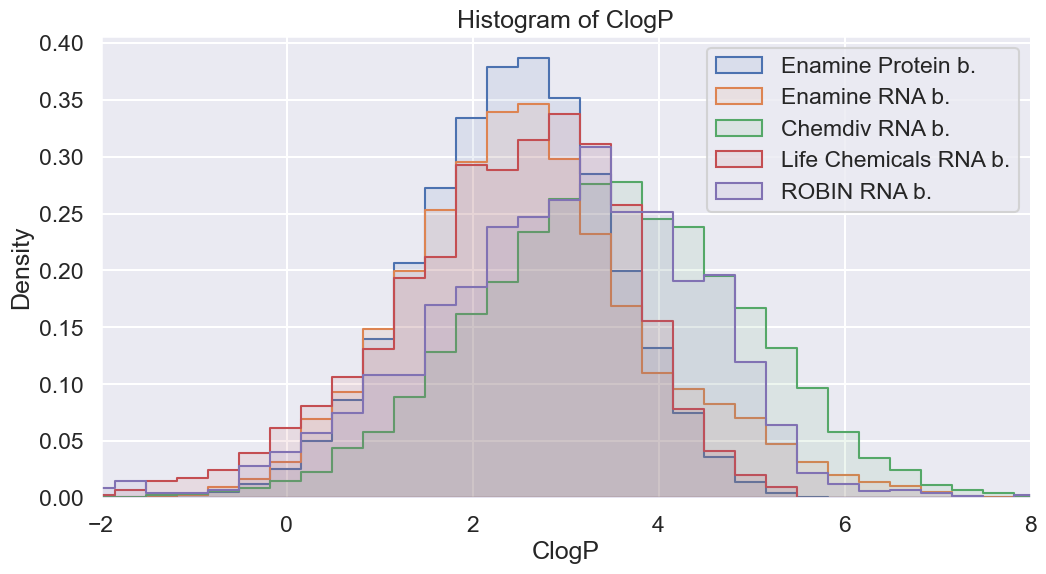

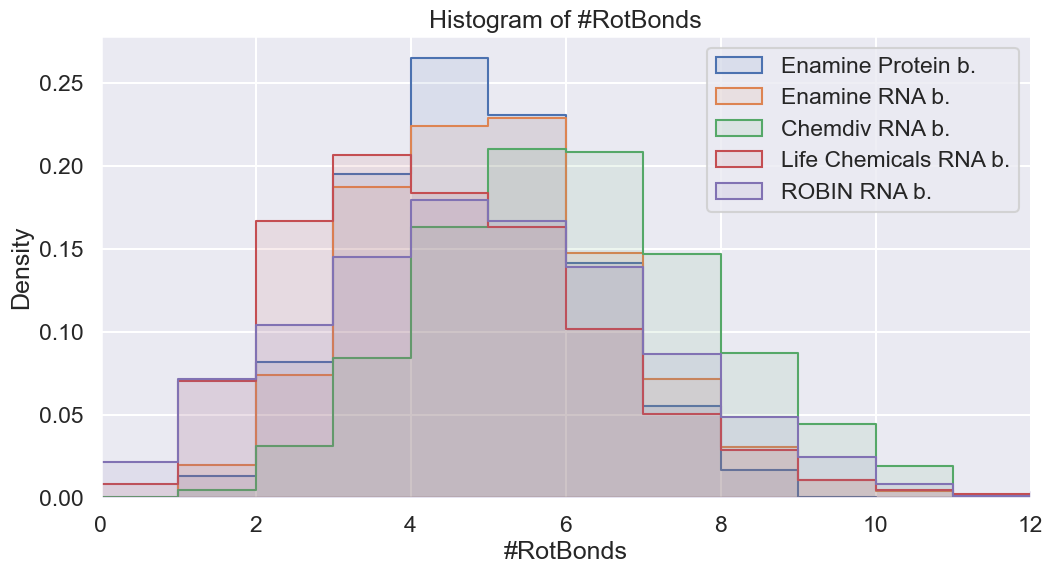

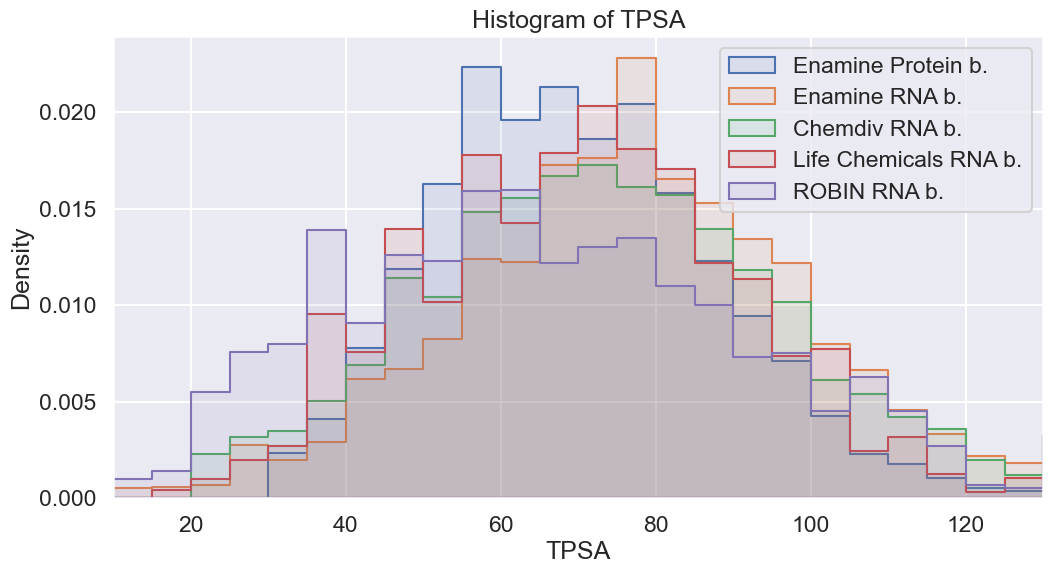

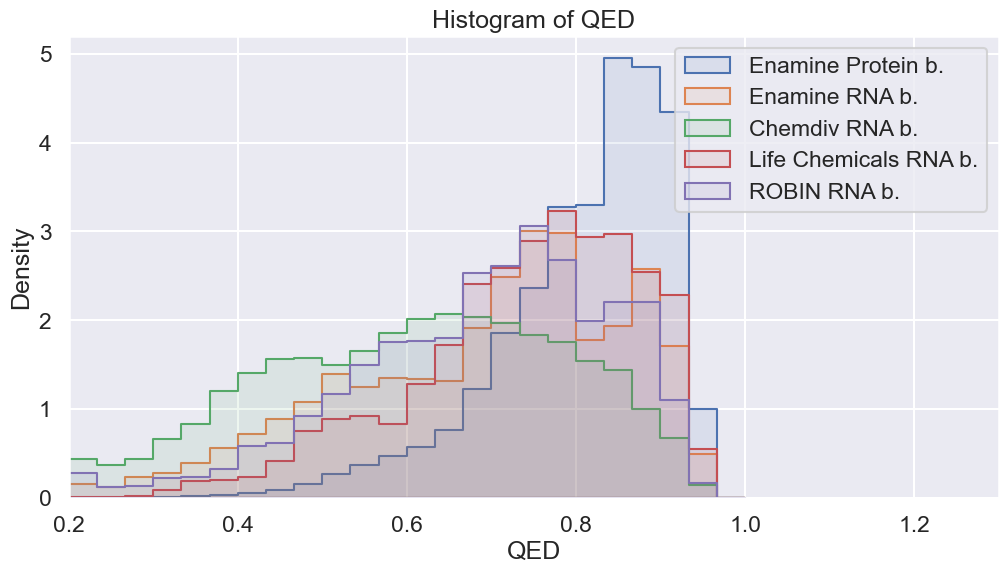

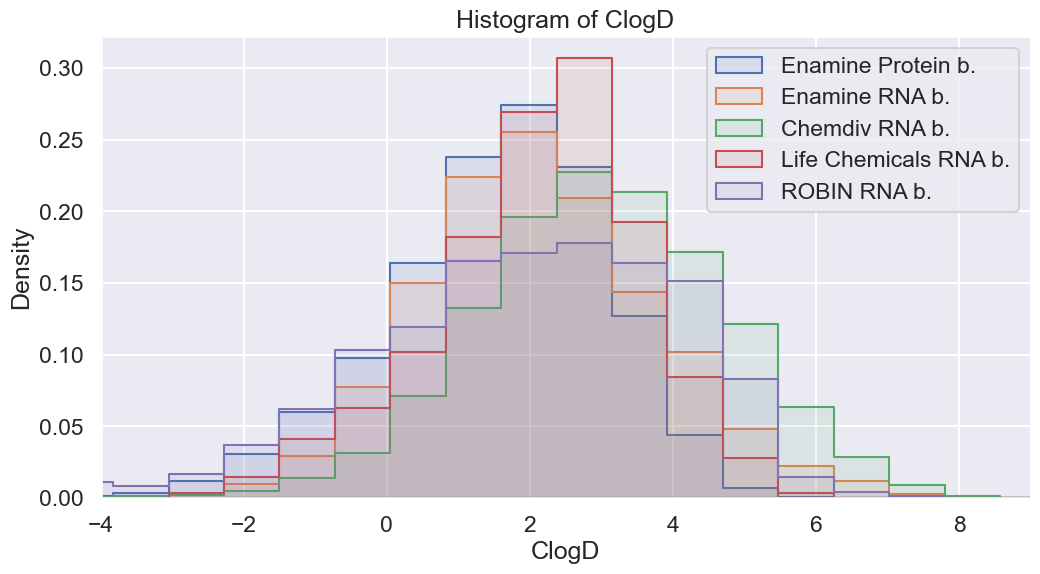

In [7]:

def get_bins(column, datasets, num_bins=50, custom_max=None, round_int=False, custom_bins=None):
    if column in ['MW', '#HeavyAtoms', 'NumO', 'NumN', 'NumC', 'NumCl', 'NumF', 'NumS', 'HBA', 'HBD', 'Rings', 'ClogP', '#RotBonds', 'TPSA', 'QED', 'ClogD']:
        if custom_bins and column in custom_bins:
            bin_edges = custom_bins[column]
        else:
            min_val = min(min(data[column]) for data in datasets)
            max_val = max(max(data[column]) for data in datasets)
            if round_int:
                min_val = int(round(min_val))
                max_val = int(round(max_val))
            if custom_max:
                max_val = min(max_val, custom_max)
            bin_edges = np.linspace(min_val, max_val, num_bins+1)
        return bin_edges
    else:
        return num_bins


def plot_histograms_seaborn(datasets, column, labels, alpha=0.1, custom_max=None, round_int=False, custom_bins=None, x_range=None):
    # set to paper
    sns.set_theme()
    sns.set_context("talk")
    
    plt.figure(figsize=(12, 6)) # 
    custom_bins = get_bins(column, datasets, custom_max=custom_max, round_int=round_int, custom_bins=custom_bins)
    
    if isinstance(custom_bins, int) or np.all(np.diff(custom_bins) > 0):
        for data, label in zip(datasets, labels):
            # modify data based on x_range
            if x_range:
                data = data.copy()  # avoid modifying original data
                data[column] = np.where(data[column] < x_range[0], x_range[0], data[column])
                data[column] = np.where(data[column] > x_range[1], x_range[1], data[column])

            ax = sns.histplot(data[column], 
                              bins=custom_bins, 
                              alpha=alpha, 
                              label=label, 
                              kde=False, 
                              element="step", 
                              stat="density")

            if x_range:
                ax.set_xlim(x_range)

        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        plt.legend(loc= 'best')
        # Save histogram for each column to histograms folder as svg in 1200 dpi
        plt.savefig(f'../output/histograms/v2/{column}_talk.pdf', dpi=300, format='pdf')
        plt.savefig(f'../output/histograms/v2/{column}_talk.png', dpi=300, format='png')
        plt.show()
    else:
        print(f'Error: Invalid bin edges for column {column}.')

        
all_dataframes = [enamine_protein_csv, enamine_rna_csv, chemdiv_rna_csv, life_chemicals_csv, robin_df_csv]
labels = ['Enamine Protein b.', 'Enamine RNA b.', 'Chemdiv RNA b.', 'Life Chemicals RNA b.', 'ROBIN RNA b.']
# dir_names = ['protein_enamine', 'merged', 'life_chemicals', 'robin']
columns = ['MW','#HeavyAtoms', 'NumO', 'NumN', 'NumC', 'NumCl', 'NumF', 'NumS', 'HBA', 'HBD', 'Rings', 'ClogP', '#RotBonds', 'TPSA', 'QED', 'ClogD']
custom_bins = {'MW': np.linspace(0, 1000, 101), 'NumO': np.linspace(0, 10, 21), 
               'HeavyAtomCount': np.linspace(0, 50, 51), 'TPSA': np.linspace(0, 200, 41),
               'QED': np.linspace(0, 1, 31), 'NumN': np.linspace(0, 10, 21), '#RotBonds': np.linspace(0, 20, 21), 'ClogD': np.linspace(-17, 14, 41)}
 


# Example of using custom bins for the 'MW' and 'NumO' columns, and cutting the tail of the 'MW' histogram
plot_histograms_seaborn(all_dataframes, 'MW', labels, custom_bins=custom_bins, x_range=(150, 550))
plot_histograms_seaborn(all_dataframes, '#HeavyAtoms', labels, custom_bins=custom_bins, x_range=(10, 40))
# Example of using the default bins for the '#HeavyAtoms' column
plot_histograms_seaborn(all_dataframes, 'NumO', labels, custom_bins=custom_bins, x_range=(0, 7))
plot_histograms_seaborn(all_dataframes, 'NumN', labels, custom_bins=custom_bins, x_range=(0, 10))
plot_histograms_seaborn(all_dataframes, 'NumC', labels, custom_bins=custom_bins, x_range=(5, 35))
plot_histograms_seaborn(all_dataframes, 'NumCl', labels, custom_bins=custom_bins, x_range=(0, 3))
plot_histograms_seaborn(all_dataframes, 'NumF', labels, x_range=(0, 4))
plot_histograms_seaborn(all_dataframes, 'NumS', labels, custom_bins=custom_bins, x_range=(0, 3))
plot_histograms_seaborn(all_dataframes, 'HBA', labels, custom_bins=custom_bins, x_range=(0, 12))
plot_histograms_seaborn(all_dataframes, 'HBD', labels, custom_bins=custom_bins, x_range=(0, 5))
plot_histograms_seaborn(all_dataframes, 'Rings', labels, custom_bins=custom_bins, x_range=(1, 7))
plot_histograms_seaborn(all_dataframes, 'ClogP', labels, custom_bins=custom_bins, x_range=(-2, 8))
plot_histograms_seaborn(all_dataframes, '#RotBonds', labels, custom_bins=custom_bins, x_range=(0, 12))
plot_histograms_seaborn(all_dataframes, 'TPSA', labels, custom_bins=custom_bins, x_range=(10, 130))
plot_histograms_seaborn(all_dataframes, 'QED', labels, custom_bins=custom_bins, x_range=(0.2, 1.3))
plot_histograms_seaborn(all_dataframes, 'ClogD', labels, custom_bins=custom_bins, x_range=(-4, 9))